In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot12DimsNS_T256_H05_tl_110data_StbleTgt  import get_config

In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [3]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()


In [4]:
config = get_config()
deltaT = config.deltaT
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
print(config.loss_factor)

2


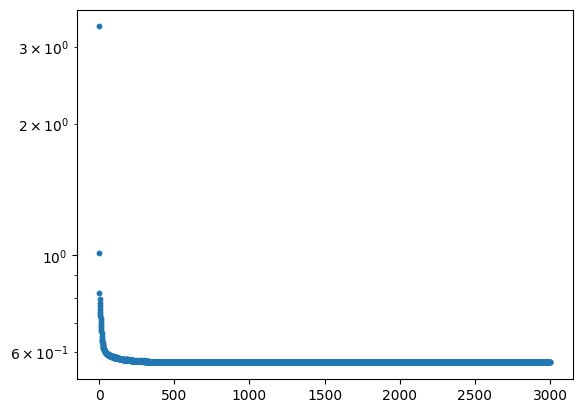

2999

In [5]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

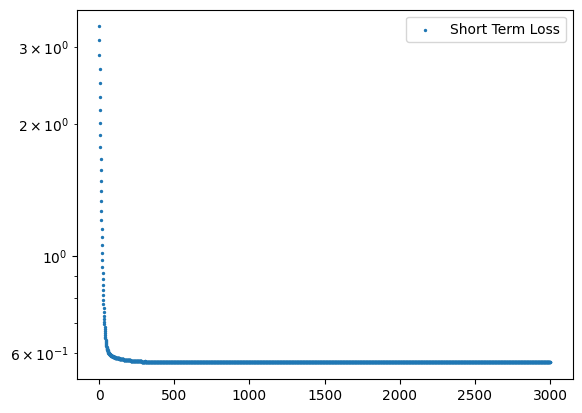

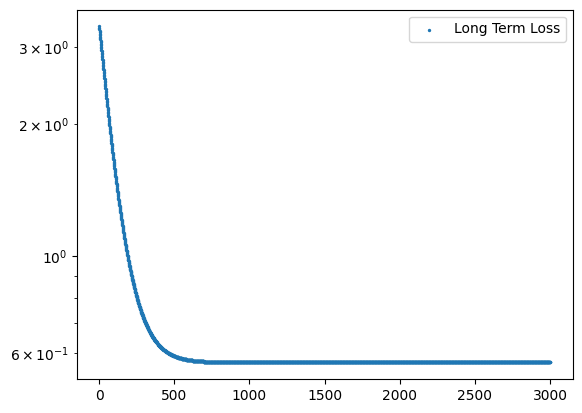

In [6]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

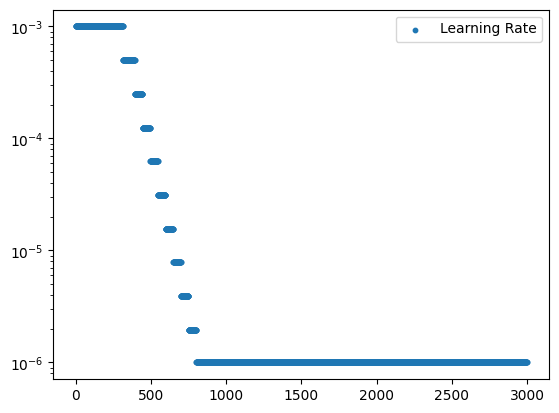

1e-06


In [7]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(LRs[-1])

In [8]:
def get_drift_files(config, ts_type):
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/12DDimsNS/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "_MLP_" in file and ts_type in file:
            if "DriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_score_dir+file)
            elif "DriftTrack" in file and "global" in file:
                driftoostrack_local_files.append(root_score_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [9]:
ts_type = f"{config.ndims}DDimsNS".replace(".", "")
drift_true_files, drift_local_files, Nepochs_track = get_drift_files(config=config, ts_type=ts_type)
print(drift_true_files,len(Nepochs_track))

['/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/12DDimsNS/TSPM_MLP_ST_0010FTh_NSTgtNFMReg_fBiPot_12DDimsNS_OOSDriftTrack_2Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/12DDimsNS/TSPM_MLP_ST_0010FTh_NSTgtNFMReg_fBiPot_12DDimsNS_OOSDriftTrack_4Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/12DDimsNS/TSPM_MLP_ST_0010FTh_NSTgtNFMReg_fBiPot_12DDimsNS_OOSDriftTrack_6Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/12

In [18]:
drift_track_rmses = {}
epochs_iter = Nepochs_track
Nepochs_keep = []
for Nepoch, true, local in zip(*[epochs_iter, drift_true_files, drift_local_files]):
    try:
        print(str(Nepoch), str(Nepoch)[-1])
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        Nepochs_keep.append(Nepoch)
    except (FileNotFoundError, ValueError, TimeoutError) as e:
        #del all_true_states, all_local_states, all_local_errors, total_local_errors
        continue
Nepochs_track = Nepochs_keep
drift_track_rmses

2 2
4 4
6 6
8 8
10 0
12 2
14 4
16 6


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_9906/2418551288.py:12: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_9906/2418551288.py:13: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


18 8
20 0
22 2
24 4
26 6
28 8
30 0
32 2
34 4
36 6
38 8
40 0
42 2
44 4
46 6
48 8
50 0
52 2
54 4
56 6
58 8
60 0
62 2
64 4
66 6
68 8
70 0
72 2
74 4
76 6
78 8
80 0
82 2
84 4
86 6
88 8
90 0
92 2
94 4
96 6
98 8
100 0
102 2
104 4
106 6
108 8
110 0
112 2
114 4
116 6
118 8
120 0
122 2
124 4
126 6
128 8
130 0
132 2
134 4
136 6
138 8
140 0
142 2
144 4
146 6
148 8
150 0
152 2
154 4
156 6
158 8
160 0
162 2
164 4
166 6
168 8
170 0
172 2
174 4
176 6
178 8
180 0
182 2
184 4
186 6
188 8
190 0
192 2
194 4
196 6
198 8
200 0
202 2
204 4
206 6
208 8
210 0
212 2
214 4
216 6
218 8
220 0
222 2
224 4
226 6
228 8
230 0
232 2
234 4
236 6
238 8
240 0
242 2
244 4
246 6
248 8
250 0
252 2
254 4
256 6
258 8
260 0
262 2
264 4
266 6
268 8
270 0
272 2
274 4
276 6
278 8
280 0
282 2
284 4
286 6
288 8
290 0
292 2
294 4
296 6
298 8
300 0
302 2
304 4
306 6
308 8
310 0
312 2
314 4
316 6
318 8
320 0
322 2
324 4
326 6
328 8
330 0
332 2
334 4
336 6
338 8
340 0
342 2
344 4
346 6
348 8
350 0
352 2
354 4
356 6
358 8
360 0
362 2
364

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_9906/2418551288.py:12: RuntimeWarning: divide by zero encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_9906/2418551288.py:13: RuntimeWarning: divide by zero encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


1676 6
1678 8
1680 0
1682 2
1684 4
1686 6
1688 8
1690 0
1692 2
1694 4
1696 6
1698 8
1700 0
1702 2
1704 4
1706 6
1708 8
1710 0
1712 2
1714 4
1716 6
1718 8
1720 0
1722 2
1724 4
1726 6
1728 8
1730 0
1732 2
1734 4
1736 6
1738 8
1740 0
1742 2
1744 4
1746 6
1748 8
1750 0
1752 2
1754 4
1756 6
1758 8
1760 0
1762 2
1764 4
1766 6
1768 8
1770 0
1772 2
1774 4
1776 6
1778 8
1780 0
1782 2
1784 4
1786 6
1788 8
1790 0
1792 2
1794 4
1796 6
1798 8
1800 0
1802 2
1804 4
1806 6
1808 8
1810 0
1812 2
1814 4
1816 6
1818 8
1820 0
1822 2
1824 4
1826 6
1828 8
1830 0
1832 2
1834 4
1836 6
1838 8
1840 0
1842 2
1844 4
1846 6
1848 8
1850 0
1852 2
1854 4
1856 6
1858 8
1860 0
1862 2
1864 4
1866 6
1868 8
1870 0
1872 2
1874 4
1876 6
1878 8
1880 0
1882 2
1884 4
1886 6
1888 8
1890 0
1892 2
1894 4
1896 6
1898 8
1900 0
1902 2
1904 4
1906 6
1908 8
1910 0
1912 2
1914 4
1916 6
1918 8
1920 0
1922 2
1924 4
1926 6
1928 8
1930 0
1932 2
1934 4
1936 6
1938 8
1940 0
1942 2
1944 4
1946 6
1948 8
1950 0
1952 2
1954 4
1956 6
1958 8
1960 0

{2: 84.14159517778543,
 4: 23.817530950557504,
 6: 20.95638153368994,
 8: 19.55855358999871,
 10: 19.181105057350376,
 12: 13.854848593627056,
 14: 20.327957825106928,
 16: 19.68653287582754,
 18: 15.260873610081664,
 20: 12.647824626286802,
 22: 13.053336288559565,
 24: 12.684274835227532,
 26: 12.242377181755648,
 28: 12.560586110228417,
 30: 12.530922978349246,
 32: 12.472963177317215,
 34: 12.057813998329005,
 36: 12.645710337155396,
 38: 12.893103901242675,
 40: 13.301613849557835,
 42: 12.958138162402102,
 44: 12.494005015277144,
 46: 12.558278822914604,
 48: 12.798873621665694,
 50: 11.826509181252012,
 52: 12.535235598675937,
 54: 12.104782443974429,
 56: 12.294070368536463,
 58: 12.276374668033776,
 60: 12.163341682454954,
 62: 12.154918700058628,
 64: 12.099182651152045,
 66: 12.384902521567007,
 68: 12.531092417216117,
 70: 12.540923679359887,
 72: 12.23651073924544,
 74: 11.910734918716445,
 76: 13.04678100102561,
 78: 12.377598741417785,
 80: 12.865858967275882,
 82: 13.00

In [19]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])
print(Nepochs_losses)

[   0    1    2 ... 2997 2998 2999]


In [20]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
print(Nepochs_losses)
common_epochs = np.intersect1d(common_epochs, np.arange(1, 3500))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]
print(track_rmses)

[   0    1    2 ... 2997 2998 2999]
[84.14159518 23.81753095 20.95638153 ... 16.33101455 17.51139133
 16.90446818]


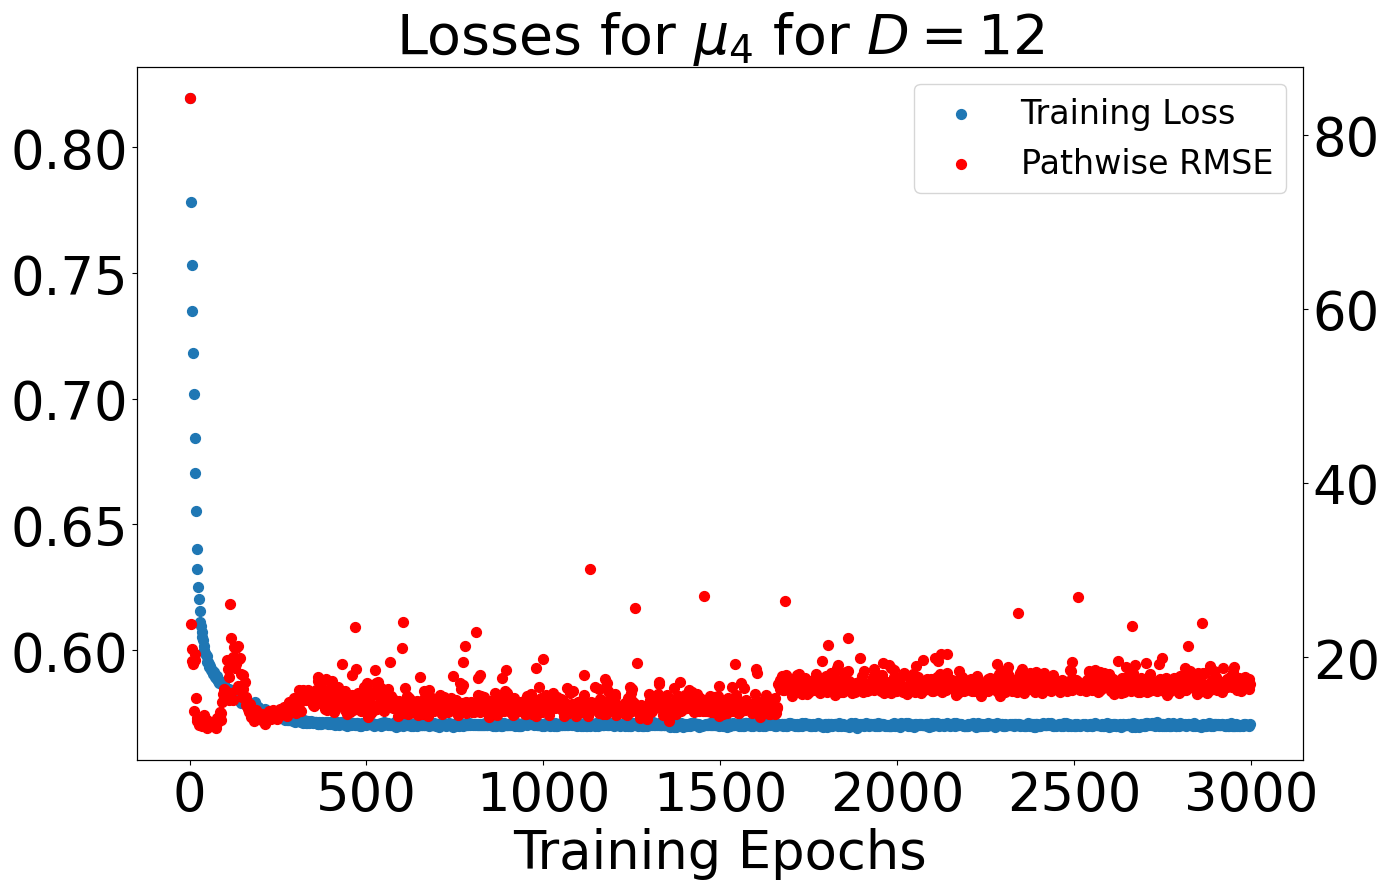

In [21]:
toSave = True
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=50, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=50, color="red",label="Pathwise RMSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Losses for $\mu_{4}$ for $D=12$", fontsize=40)
ax.tick_params(axis="both",labelsize=38)
ax2.tick_params(axis="both",labelsize=38)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/12DDimsNS/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDimsNS_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
curr_rmse = np.inf
toSave = True
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    ff_idx = np.argwhere(Nepoch == np.array(epochs_iter))[0,0]
    true = drift_true_files[ff_idx]
    local = drift_local_files[ff_idx]
    try:
        num_diff_times = 1
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        print(all_local_states.shape)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)<
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Score Estimator for $\mu_4$",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/12DDimsNS/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDimsNS_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        continue

In [ ]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.resource_logging_path, inclusive=False)
data